
# Some settings and configurations

In [1]:
import ex_config
ex_config.load_caffe()

caffe 1.0.0-rc3 loaded


# Functions to save data to LMDB

In [2]:
def initiate_lmdb(lmdb_name, drop_existing = False):
    import lmdb
    import caffe
    import numpy as np
    
    if drop_existing:
        import os
        import shutil
        if os.path.exists(lmdb_name):
            shutil.rmtree(lmdb_name) 
    
    env = lmdb.open(lmdb_name, map_size=int(1e12))
    print('database debug info:', env.stat())
    return env

In [3]:
def write_to_transaction(txn, data, label, key):
    import caffe
    datum = caffe.proto.caffe_pb2.Datum()
    (datum.channels, datum.height, datum.width) = data.shape
    datum.data = data.tobytes()
    datum.label = label
    key = '{:08}'.format(key)
    txn.put(key.encode('ascii'), datum.SerializeToString())

In [4]:
def array_to_proto(data, proto_name):
    import caffe
    blob = caffe.io.array_to_blobproto(data)
    binaryproto_file = open(proto_name, 'wb+')
    binaryproto_file.write(blob.SerializeToString())
    binaryproto_file.close()

# Functions to validate LMDB

In [5]:
def debug_lmdb_print_info(lmdb_name):
    import caffe
    print('debug printing for \'', lmdb_name, '\' lmdb data')
    env = initiate_lmdb(lmdb_name, drop_existing = False)
    print(env.stat())
    with env.begin() as txn:
        cursor = txn.cursor()
        datum = caffe.proto.caffe_pb2.Datum()
        i = 0
        for key, value in cursor:
            i += 1
            datum.ParseFromString(value)
            print('inst %d of size (%d, %d, %d) labeled %d' % (i, datum.channels, datum.height, datum.width, datum.label))

In [6]:
def debug_lmdb_plot_slices(lmdb_name, data_type, print_slices=False):
    import ex_utils
    import numpy as np
    #np.set_printoptions(threshold=np.inf)
    import caffe
    import matplotlib.pyplot as plt
    print('debug plotting slices for \'%s\' lmdb data' % lmdb_name)
    env = initiate_lmdb(lmdb_name, drop_existing = False)
    with env.begin() as txn:
        cursor = txn.cursor()
        datum = caffe.proto.caffe_pb2.Datum()
        cursor.next();
        value = cursor.value();
        datum.ParseFromString(value)
        flat_x = np.fromstring(datum.data, dtype=data_type)
        x = flat_x.reshape(datum.channels, datum.height, datum.width)
        ex_utils.debug_plot_median_slices(x, print_slices)

# Functions to postprocess data lists

In [7]:
def split_mri_dti(item_list):
    mri_list = [(i[0], i[1], i[3]) for i in item_list]
    dti_list = [(i[0], i[2], i[3]) for i in item_list]
    return mri_list, dti_list

In [8]:
def split_lists_to_binary_groups(lists):
    import ex_config as cfg
    bin_groups = { lbl: [] for lbl in cfg.get_label_families() }
    for item in lists:
        for f in cfg.get_label_families(item[0]):
            bin_groups[f].append(item)
    return bin_groups

# Functions to preprocess data and create lmdb

In [9]:
def preprocess(list_item, adni_root, data_type, max_augm_shift, crop_params=None, crop_roi_params=None):
    import ex_utils
    nii = ex_utils.get_nii_from_folder(adni_root + list_item[1])[0]
    array = ex_utils.nii_to_array(nii, data_type)
    if crop_params != None:
        array = ex_utils.crop_border(array, crop_prc=crop_params['prc'], shift_prc=crop_params['shift'])
    augm = ex_utils.augment(array, max_augm_shift, list_item[2])
    if crop_roi_params != None:
        crp = crop_roi_params # (min_x, max_x, min_y, max_y, min_z, max_z)
        augm = augm[crp[0]:crp[1], crp[2]:crp[3], crp[4]:crp[5]]
    return augm

In [10]:
def make_lmdb(one_modality_list, adni_root, data_type, lmdb_name, label_family, max_augm_shift, crop_params=None, crop_roi_params=None):
    import ex_config
    env = initiate_lmdb(lmdb_name, drop_existing = True)
    key = 0
    with env.begin(write=True) as txn:
        for i in one_modality_list:
            augm = preprocess(i, adni_root, data_type, max_augm_shift, crop_params, crop_roi_params)
            print('%d. writing image of shape %s to lmdb (%s)' % (key, str(augm.shape), i[1]))
            write_to_transaction(txn, augm, ex_config.get_label_code(label_family, i[0]), key)
            key += 1

# Functions to generate mean file

In [11]:
def calc_lmdb_mean(lmdb_path, data_type, reshape_4D = True, plot_mean = True):
    import ex_utils
    import caffe
    import numpy as np
    import matplotlib.pyplot as plt
    
    env = initiate_lmdb(lmdb_path, drop_existing = False)
    mean = np.empty
    i = 0
    with env.begin() as txn:
        datum = caffe.proto.caffe_pb2.Datum()
        cursor = txn.cursor()
        cursor.next();
        datum.ParseFromString(cursor.value())
        mean = np.zeros([datum.channels, datum.height, datum.width])
        cursor = txn.cursor()
        for key, value in cursor:
            i += 1
            datum.ParseFromString(value)
            flat = np.fromstring(datum.data, dtype=data_type)
            x = flat.reshape(datum.channels, datum.height, datum.width)
            mean = np.add(mean, x)
    mean = np.divide(mean, i)
    if plot_mean:
        ex_utils.debug_plot_median_slices(mean)
    if reshape_4D:
        mean = mean.reshape((1,) + mean.shape)
        print('mean image reshaped to', mean.shape)
    return mean

# An example of how to do data preprocessing

Preprocessing params

In [12]:
import numpy as np

lmdb_params = {
    'adni_root': '/home/xubiker/ADNI_Multimodal/dataset/',
    'max_augm': {'shift': 2, 'blur': 1.2},
    'dtype': np.float,

    'crop_params': None,#{'shift': (0, 0, -0.05), 'prc': (0.05, 0.05, 0.05)},
    'crop_roi_params': (65-2, 92+1-2, 58-2, 85+1-2, 31-2, 58+1-2) # max_shift substracted
}

Process lists. Write them to lmdb.

In [14]:
def generate_lmdb(lst, lmdb_name, label_family, params):
    make_lmdb(one_modality_list=lst, adni_root=params['adni_root'], data_type=params['dtype'],
              lmdb_name=lmdb_name,
              label_family=label_family,
              max_augm_shift=params['max_augm']['shift'],
              crop_params=params['crop_params'], crop_roi_params=params['crop_roi_params']
             )
    debug_lmdb_print_info(lmdb_name)
    debug_lmdb_plot_slices(lmdb_name, data_type=params['dtype'])
    mean = calc_lmdb_mean(lmdb_path=lmdb_name, data_type=params['dtype'], reshape_4D=True, plot_mean=True)
    array_to_proto(data=mean, proto_name=lmdb_name+'_mean.binaryproto')    

In [15]:
def generate_lmdb_from_lists(lists_file_path, params, create_binary_lmdbs=False, normalize_labels=False):
    
    import pickle
    with open(lists_file_path, 'rb') as f:
        train_list, valid_list, test_list = pickle.load(f)
    
    train_mri_list, train_dti_list = split_mri_dti(train_list)
    valid_mri_list, valid_dti_list = split_mri_dti(valid_list)
    test_mri_list, test_dti_list = split_mri_dti(test_list)

#     lists_with_names = zip(
#         [train_mri_list, valid_mri_list, test_mri_list, train_dti_list, valid_dti_list, test_dti_list],
#         ['alz_sMRI_train', 'alz_sMRI_valid', 'alz_sMRI_test', 'alz_MD_train', 'alz_MD_valid', 'alz_MD_test'])
    lists_with_names = zip(
        [test_mri_list],
        ['alz_MRI_test'])

    for (lst, name) in lists_with_names:
        queue = [(lst, name, 'ternary')]
        if create_binary_lmdbs:
            queue = []
            bin_groups = split_lists_to_binary_groups(lst)
            for k in bin_groups:
                label_family = k if normalize_labels else 'ternary'
                queue.append((bin_groups[k], name + '_' + k, label_family))
        for (l, n, f) in queue:
            generate_lmdb(l, n, f, params)

database debug info: {'depth': 0, 'overflow_pages': 0, 'entries': 0, 'psize': 4096, 'leaf_pages': 0, 'branch_pages': 0}
0. writing image of shape (28, 28, 28) to lmdb (/AD/016_S_4887/SMRI/)
1. writing image of shape (28, 28, 28) to lmdb (/AD/127_S_5058/SMRI/)
2. writing image of shape (28, 28, 28) to lmdb (/NC/098_S_4506/SMRI/)
3. writing image of shape (28, 28, 28) to lmdb (/AD/027_S_4964/SMRI/)
4. writing image of shape (28, 28, 28) to lmdb (/NC/003_S_4081/SMRI/)
5. writing image of shape (28, 28, 28) to lmdb (/NC/129_S_4422/SMRI/)
6. writing image of shape (28, 28, 28) to lmdb (/NC/021_S_4558/SMRI/)
7. writing image of shape (28, 28, 28) to lmdb (/NC/127_S_4198/SMRI/)
8. writing image of shape (28, 28, 28) to lmdb (/AD/027_S_4938/SMRI/)
9. writing image of shape (28, 28, 28) to lmdb (/NC/029_S_4585/SMRI/)
10. writing image of shape (28, 28, 28) to lmdb (/AD/094_S_4737/SMRI/)
11. writing image of shape (28, 28, 28) to lmdb (/NC/016_S_4121/SMRI/)
12. writing image of shape (28, 28, 28

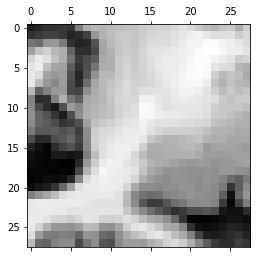

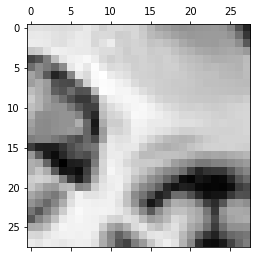

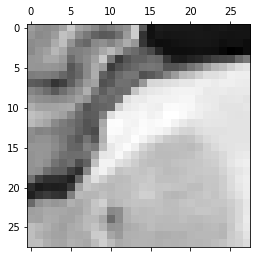

database debug info: {'depth': 1, 'overflow_pages': 1032, 'entries': 24, 'psize': 4096, 'leaf_pages': 1, 'branch_pages': 0}


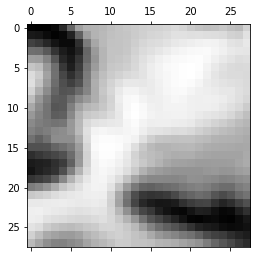

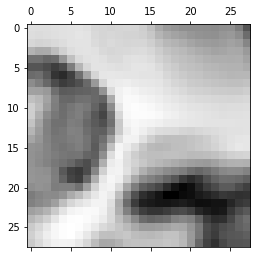

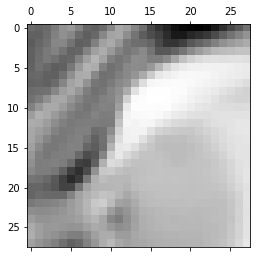

mean image reshaped to (1, 28, 28, 28)
database debug info: {'depth': 0, 'overflow_pages': 0, 'entries': 0, 'psize': 4096, 'leaf_pages': 0, 'branch_pages': 0}
0. writing image of shape (28, 28, 28) to lmdb (/MCI/027_S_4955/SMRI/)
1. writing image of shape (28, 28, 28) to lmdb (/AD/016_S_4887/SMRI/)
2. writing image of shape (28, 28, 28) to lmdb (/AD/127_S_5058/SMRI/)
3. writing image of shape (28, 28, 28) to lmdb (/AD/027_S_4964/SMRI/)
4. writing image of shape (28, 28, 28) to lmdb (/MCI/127_S_4210/SMRI/)
5. writing image of shape (28, 28, 28) to lmdb (/MCI/027_S_4873/SMRI/)
6. writing image of shape (28, 28, 28) to lmdb (/MCI/109_S_2110/SMRI/)
7. writing image of shape (28, 28, 28) to lmdb (/MCI/109_S_4455/SMRI/)
8. writing image of shape (28, 28, 28) to lmdb (/AD/027_S_4938/SMRI/)
9. writing image of shape (28, 28, 28) to lmdb (/MCI/016_S_2031/SMRI/)
10. writing image of shape (28, 28, 28) to lmdb (/AD/094_S_4737/SMRI/)
11. writing image of shape (28, 28, 28) to lmdb (/AD/016_S_4353/

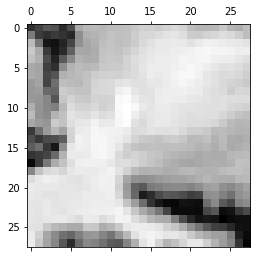

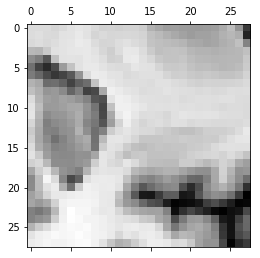

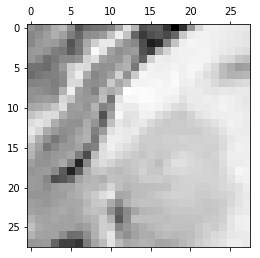

database debug info: {'depth': 1, 'overflow_pages': 1032, 'entries': 24, 'psize': 4096, 'leaf_pages': 1, 'branch_pages': 0}


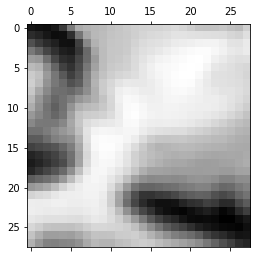

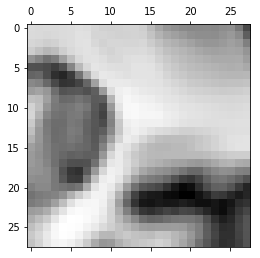

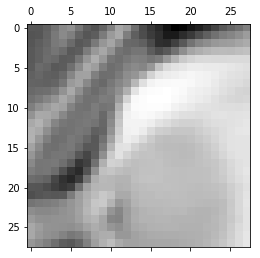

mean image reshaped to (1, 28, 28, 28)
database debug info: {'depth': 0, 'overflow_pages': 0, 'entries': 0, 'psize': 4096, 'leaf_pages': 0, 'branch_pages': 0}
0. writing image of shape (28, 28, 28) to lmdb (/MCI/027_S_4955/SMRI/)
1. writing image of shape (28, 28, 28) to lmdb (/NC/098_S_4506/SMRI/)
2. writing image of shape (28, 28, 28) to lmdb (/MCI/127_S_4210/SMRI/)
3. writing image of shape (28, 28, 28) to lmdb (/NC/003_S_4081/SMRI/)
4. writing image of shape (28, 28, 28) to lmdb (/NC/129_S_4422/SMRI/)
5. writing image of shape (28, 28, 28) to lmdb (/NC/021_S_4558/SMRI/)
6. writing image of shape (28, 28, 28) to lmdb (/MCI/027_S_4873/SMRI/)
7. writing image of shape (28, 28, 28) to lmdb (/MCI/109_S_2110/SMRI/)
8. writing image of shape (28, 28, 28) to lmdb (/NC/127_S_4198/SMRI/)
9. writing image of shape (28, 28, 28) to lmdb (/MCI/109_S_4455/SMRI/)
10. writing image of shape (28, 28, 28) to lmdb (/NC/029_S_4585/SMRI/)
11. writing image of shape (28, 28, 28) to lmdb (/MCI/016_S_2031/

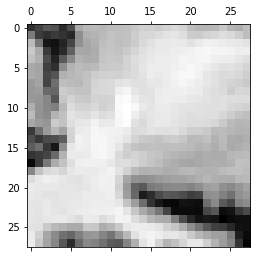

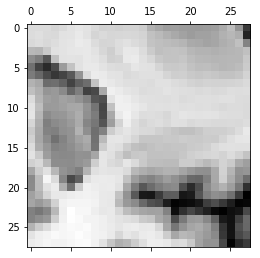

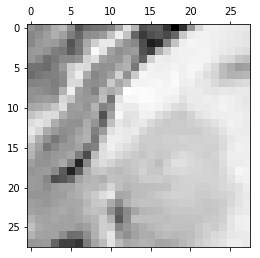

database debug info: {'depth': 1, 'overflow_pages': 1032, 'entries': 24, 'psize': 4096, 'leaf_pages': 1, 'branch_pages': 0}


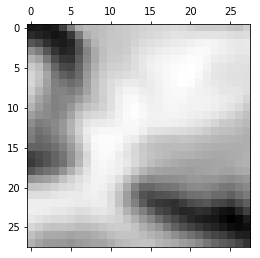

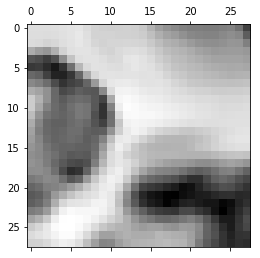

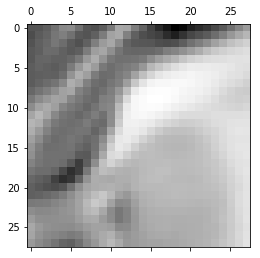

mean image reshaped to (1, 28, 28, 28)


In [16]:
generate_lmdb_from_lists('lists.pkl', lmdb_params, create_binary_lmdbs=True, normalize_labels=True)